In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 28.9 MB/s 
     |████████████████████████████████| 9.8 MB 21.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import numpy as np
#from pandas import datetime
import matplotlib.pyplot as plt
from numpy import log
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [15]:
import chardet
file="/content/data_1981_95.csv"
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.73, 'encoding': 'ISO-8859-1', 'language': ''}

In [16]:
df=pd.read_csv(file, delimiter=",", encoding='ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,31,33,54,61,62,76,79,94,96,121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
df.rename(columns={'iyear':'year','iday':'day','imonth':'month'},inplace=True)
df['attack_date'] = pd.to_datetime(df[['year','month','day']],  errors = 'coerce')

In [18]:

df.nkill=df.nkill.dropna()

In [ ]:
print("null values in kill",pd.isnull(df['nkill']).sum())
print("null values in days",pd.isnull(df['attack_date']).sum())
df = df[df['nkill'].notna()]
df=df[df['attack_date'].notna()]

In [7]:
x_day=df['attack_date']
y_nkill=df['nkill']

In [8]:
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print(len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill[6000:6383]


null values in kill 0
null values in years 0
10724


In [9]:
model = SARIMAX(train_nkill, order=(2, 1, 3),)
fitted = model.fit(disp=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  nkill   No. Observations:                 6000
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -23513.985
Date:                Tue, 25 Jan 2022   AIC                          47039.969
Time:                        23:12:40   BIC                          47080.165
Sample:                             0   HQIC                         47053.928
                               - 6000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6917      0.491     -1.410      0.159      -1.653       0.270
ar.L2          0.1013      0.365      0.277      0.781      -0.614       0.816
ma.L1         -0.2492      0.491     -0.508      0.612      -1.211       0.713
ma.L2         -0.7951      0.679     -1.170      0.242      -2.127       0.536
ma.L3          0.0487      0.352      0.138      0.890      -0.641       0.738
sigma2       148.6345      0.303    491.135      0.000     148.041     149.228
===================================================================================
Ljung-Box (Q):                       32.93   Jarque-Bera (JB):           7571192.98
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               4.91   Skew:                            10.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       175.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
   # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


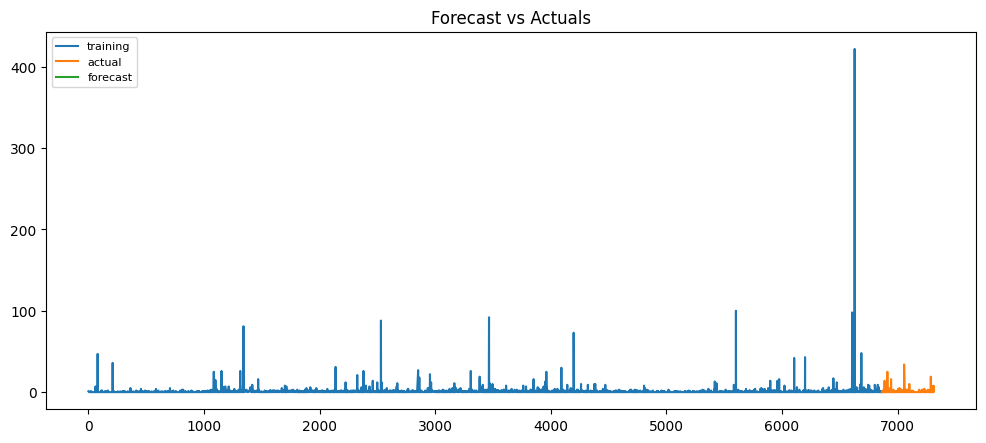

In [12]:
fc = fitted.forecast(383, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_nkill.index)
#lower_series = pd.Series(conf[:, 0], index=test_nkill.index)
#upper_series = pd.Series(conf[:, 1], index=test_nkill.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_nkill, label='training')
plt.plot(test_nkill, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
forecast_accuracy(fc, test_nkill.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'corr': -0.10996574027893438,
 'mae': 1.684462456399594,
 'mape': inf,
 'me': 0.8514177736133963,
 'minmax': 0.8073223296731383,
 'mpe': inf,
 'rmse': 2.901543771166904}

In [14]:
fitted.save('Smodel_1970_80.pkl')

In [ ]:
dfp1=df.loc[(df['attack_date']>='1970-01-01') &( df['attack_date']<='1980-12-30')]
dfp2=df.loc[(df['attack_date']>='1981-01-01') &( df['attack_date']<='1995-12-30')]
dfp3=df.loc[(df['attack_date']>='1996-01-01') &( df['attack_date']<='2010-12-30')]
dfp4=df.loc[(df['attack_date']>='2011-01-01') &( df['attack_date']<='2012-12-30')]
dfp5=df.loc[(df['attack_date']>='2013-01-01') &( df['attack_date']<='2014-12-30')]
dfp6=df.loc[(df['attack_date']>='2015-01-01') &( df['attack_date']<='2017-12-30')]


In [ ]:
x_day=dfp1['attack_date']
y_nkill=dfp1['nkill']
y_nkill=y_nkill.astype(int)
print("toatl len",len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill.iloc[6000:6383]
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print("lenght test",len(test_nkill))
print(len(y_nkill))

model=SARIMAX(train_nkill,order=(2,1,2))
fitted = model.fit()
fitted.summary()

toatl len 6383
null values in kill 0
null values in years 0
lenght test 383
6383


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  nkill   No. Observations:                 6000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -19724.275
Date:                Sat, 22 Jan 2022   AIC                          39458.550
Time:                        04:54:41   BIC                          39492.047
Sample:                             0   HQIC                         39470.183
                               - 6000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9633      0.105     -9.172      0.000      -1.169      -0.757
ar.L2         -0.0025      0.033     -0.077      0.938      -0.067       0.062
ma.L1         -0.0311      0.098     -0.318      0.750      -0.223       0.161
ma.L2         -0.9625      0.095    -10.160      0.000      -1.148      -0.777
sigma2        41.9781      0.090    468.625      0.000      41.803      42.154
===================================================================================
Ljung-Box (Q):                      158.88   Jarque-Bera (JB):        2255536479.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.32   Skew:                            48.68
Prob(H) (two-sided):                  0.00   Kurtosis:                      3005.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


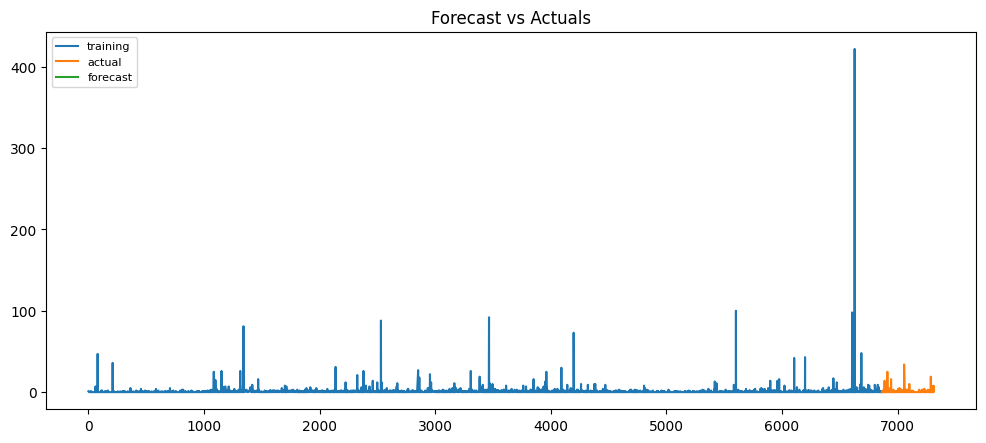

In [ ]:




#model = ARIMA(train, order=(1, 1, 1))  
#fitted = model.fit(disp=-1)  

# Forecast

fc= fitted.forecast(383, alpha=0.05)  # 95% conf



# Make as pandas series
fc_series = pd.Series(fc, index=test_nkill.index)
#lower_series = pd.Series(conf[:, 0], index=test_nkill.index)
#upper_series = pd.Series(conf[:, 1], index=test_nkill.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_nkill, label='training')
plt.plot(test_nkill, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()







fitted.save('Smodel1_1970-01-01_1980-12-30.pkl')

In [ ]:
forecast_accuracy(fc, test_nkill.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'corr': 0.008425344335959742,
 'mae': 1.6789742070037819,
 'mape': inf,
 'me': 0.8447921409407443,
 'minmax': 0.8070342189767014,
 'mpe': inf,
 'rmse': 2.8985735878100147}

In [ ]:
dfp2=df.loc[(df['attack_date']>='1981-01-01') |( df['attack_date']<='1995-12-30')]

In [ ]:
x_day=dfp2['attack_date']
y_nkill=dfp2['nkill']
y_nkill=y_nkill.astype(int)
print("toatl len",len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill.iloc[6000:6383]
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print("lenght test",len(test_nkill))
print(len(y_nkill))



toatl len 6383
null values in kill 0
null values in years 0
lenght test 383
6383


In [ ]:
model=SARIMAX(train_nkill,order=(2,1,2))
fitted = model.fit()
fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  nkill   No. Observations:                 6000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -19724.275
Date:                Sat, 22 Jan 2022   AIC                          39458.550
Time:                        05:14:04   BIC                          39492.047
Sample:                             0   HQIC                         39470.183
                               - 6000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9633      0.105     -9.172      0.000      -1.169      -0.757
ar.L2         -0.0025      0.033     -0.077      0.938      -0.067       0.062
ma.L1         -0.0311      0.098     -0.318      0.750      -0.223       0.161
ma.L2         -0.9625      0.095    -10.160      0.000      -1.148      -0.777
sigma2        41.9781      0.090    468.625      0.000      41.803      42.154
===================================================================================
Ljung-Box (Q):                      158.88   Jarque-Bera (JB):        2255536479.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.32   Skew:                            48.68
Prob(H) (two-sided):                  0.00   Kurtosis:                      3005.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


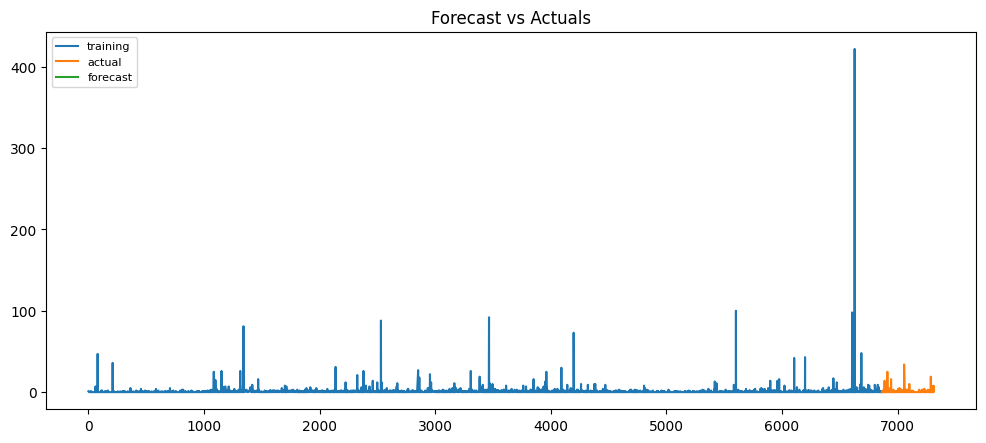

In [ ]:


#model = ARIMA(train, order=(1, 1, 1))  
#fitted = model.fit(disp=-1)  

# Forecast

fc= fitted.forecast(383, alpha=0.05)  # 95% conf



# Make as pandas series
fc_series = pd.Series(fc, index=test_nkill.index)
#lower_series = pd.Series(conf[:, 0], index=test_nkill.index)
#upper_series = pd.Series(conf[:, 1], index=test_nkill.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_nkill, label='training')
plt.plot(test_nkill, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()







fitted.save('Smodel1_1981-01-01_1995-12-30.pkl')

In [ ]:
forecast_accuracy(fc, test_nkill.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'corr': 0.008425344335959742,
 'mae': 1.6789742070037819,
 'mape': inf,
 'me': 0.8447921409407443,
 'minmax': 0.8070342189767014,
 'mpe': inf,
 'rmse': 2.8985735878100147}

In [ ]:
dfp3=df.loc[(df['attack_date']>='1996-01-01') |( df['attack_date']<='2010-12-30')]
dfp3

,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,...,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,attack_date
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-07-02
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,North America,Illinois,Cairo,37.005105,-89.176269,1,0,NaN,1/1/1970: Unknown African American assailants ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Cairo Police Department,Cairo Police Headquarters,...,NaN,Several gunshots were fired.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-01
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,South America,Montevideo,Montevideo,-34.891151,-56.187214,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,0,0,1,Assassination,NaN,NaN,NaN,NaN,3,Police,25.0,Police Security Forces/Officers,Uruguayan Police,Juan Maria de Lucah/Chief of Directorate of in...,...,NaN,Automatic firearm,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-01-02
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,North America,California,Oakland,37.791927,-122.225906,1,0,Edes Substation,1/2/1970: Unknown perpetrators detonated explo...,1,1,1,1,2.0,Other Crime Type,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,21,Utilities,107.0,Electricity,Pacific Gas & Electric Company,Edes Substation,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),22500.0,Three transformers were damaged.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-02
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,North America,Wisconsin,Madison,43.076592,-89.412488,1,0,NaN,"1/2/1970: Karl Armstrong, a member of the New ...",1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,4,Military,28.0,Military Recruiting Station/Academy,R.O.T.C.,"R.O.T.C. offices at University of Wisconsin, M...",...,NaN,Firebomb consisting of gasoline,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),60000.0,"Basketball courts, weight room, swimming pool,...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0.0,0.0,0.0,0.0,NaN,1970-01

In [ ]:
x_day=dfp3['attack_date']
y_nkill=dfp3['nkill']
y_nkill=y_nkill.astype(int)
print("toatl len",len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill.iloc[6000:6383]
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print("lenght test",len(test_nkill))
print(len(y_nkill))

toatl len 6383
null values in kill 0
null values in years 0
lenght test 383
6383


In [ ]:
model=SARIMAX(train_nkill,order=(2,1,2))
fitted = model.fit()
fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  nkill   No. Observations:                 6000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -19724.275
Date:                Sat, 22 Jan 2022   AIC                          39458.550
Time:                        05:37:27   BIC                          39492.047
Sample:                             0   HQIC                         39470.183
                               - 6000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9633      0.105     -9.172      0.000      -1.169      -0.757
ar.L2         -0.0025      0.033     -0.077      0.938      -0.067       0.062
ma.L1         -0.0311      0.098     -0.318      0.750      -0.223       0.161
ma.L2         -0.9625      0.095    -10.160      0.000      -1.148      -0.777
sigma2        41.9781      0.090    468.625      0.000      41.803      42.154
===================================================================================
Ljung-Box (Q):                      158.88   Jarque-Bera (JB):        2255536479.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.32   Skew:                            48.68
Prob(H) (two-sided):                  0.00   Kurtosis:                      3005.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


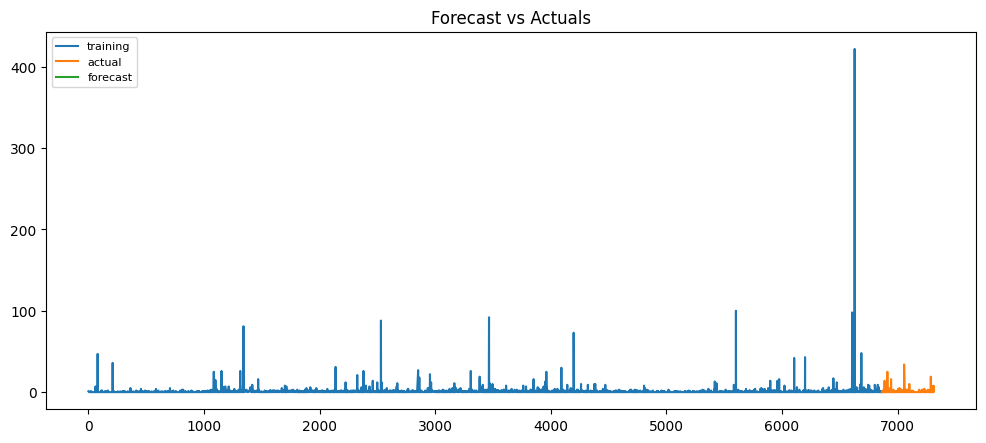

In [ ]:


#model = ARIMA(train, order=(1, 1, 1))  
#fitted = model.fit(disp=-1)  

# Forecast

fc= fitted.forecast(383, alpha=0.05)  # 95% conf



# Make as pandas series
fc_series = pd.Series(fc, index=test_nkill.index)
#lower_series = pd.Series(conf[:, 0], index=test_nkill.index)
#upper_series = pd.Series(conf[:, 1], index=test_nkill.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_nkill, label='training')
plt.plot(test_nkill, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()







fitted.save('Smodel1_1996-01-01_2010-12-30.pkl')

In [ ]:
forecast_accuracy(fc, test_nkill.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'corr': 0.008425344335959742,
 'mae': 1.6789742070037819,
 'mape': inf,
 'me': 0.8447921409407443,
 'minmax': 0.8070342189767014,
 'mpe': inf,
 'rmse': 2.8985735878100147}

In [ ]:
dfp4=df.loc[(df['attack_date']>='2011-01-01') |( df['attack_date']<='2012-12-30')]
dfp4

,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,...,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,attack_date
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-07-02
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,North America,Illinois,Cairo,37.005105,-89.176269,1,0,NaN,1/1/1970: Unknown African American assailants ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Cairo Police Department,Cairo Police Headquarters,...,NaN,Several gunshots were fired.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-01
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,South America,Montevideo,Montevideo,-34.891151,-56.187214,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,0,0,1,Assassination,NaN,NaN,NaN,NaN,3,Police,25.0,Police Security Forces/Officers,Uruguayan Police,Juan Maria de Lucah/Chief of Directorate of in...,...,NaN,Automatic firearm,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-01-02
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,North America,California,Oakland,37.791927,-122.225906,1,0,Edes Substation,1/2/1970: Unknown perpetrators detonated explo...,1,1,1,1,2.0,Other Crime Type,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,21,Utilities,107.0,Electricity,Pacific Gas & Electric Company,Edes Substation,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),22500.0,Three transformers were damaged.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-02
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,North America,Wisconsin,Madison,43.076592,-89.412488,1,0,NaN,"1/2/1970: Karl Armstrong, a member of the New ...",1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,4,Military,28.0,Military Recruiting Station/Academy,R.O.T.C.,"R.O.T.C. offices at University of Wisconsin, M...",...,NaN,Firebomb consisting of gasoline,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),60000.0,"Basketball courts, weight room, swimming pool,...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0.0,0.0,0.0,0.0,NaN,1970-01

In [ ]:
x_day=dfp4['attack_date']
y_nkill=dfp4['nkill']
y_nkill=y_nkill.astype(int)
print("toatl len",len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill.iloc[6000:6383]
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print("lenght test",len(test_nkill))
print(len(y_nkill))

toatl len 6383
null values in kill 0
null values in years 0
lenght test 383
6383


In [ ]:
model=SARIMAX(train_nkill,order=(2,1,2))
fitted = model.fit()
fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  nkill   No. Observations:                 6000
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -19724.275
Date:                Sat, 22 Jan 2022   AIC                          39458.550
Time:                        05:58:52   BIC                          39492.047
Sample:                             0   HQIC                         39470.183
                               - 6000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9633      0.105     -9.172      0.000      -1.169      -0.757
ar.L2         -0.0025      0.033     -0.077      0.938      -0.067       0.062
ma.L1         -0.0311      0.098     -0.318      0.750      -0.223       0.161
ma.L2         -0.9625      0.095    -10.160      0.000      -1.148      -0.777
sigma2        41.9781      0.090    468.625      0.000      41.803      42.154
===================================================================================
Ljung-Box (Q):                      158.88   Jarque-Bera (JB):        2255536479.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.32   Skew:                            48.68
Prob(H) (two-sided):                  0.00   Kurtosis:                      3005.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


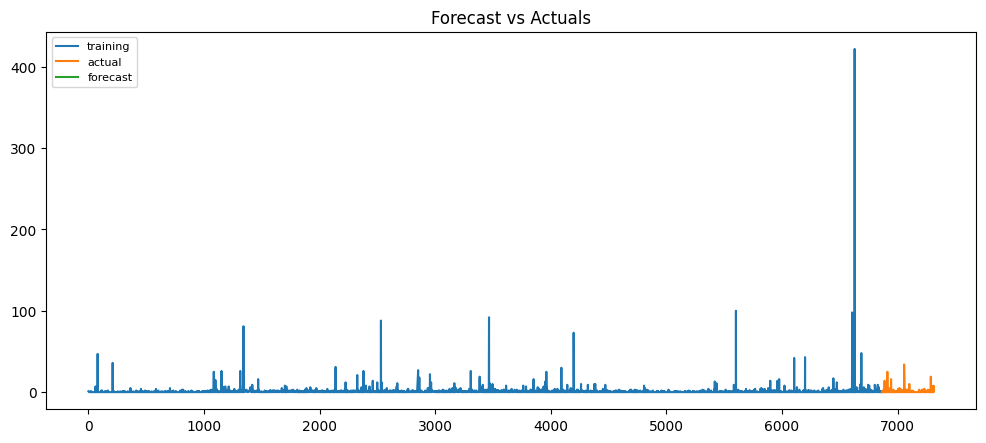

In [ ]:


#model = ARIMA(train, order=(1, 1, 1))  
#fitted = model.fit(disp=-1)  

# Forecast

fc= fitted.forecast(383, alpha=0.05)  # 95% conf



# Make as pandas series
fc_series = pd.Series(fc, index=test_nkill.index)
#lower_series = pd.Series(conf[:, 0], index=test_nkill.index)
#upper_series = pd.Series(conf[:, 1], index=test_nkill.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_nkill, label='training')
plt.plot(test_nkill, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()







fitted.save('Smodel1_2011-01-01_2012-12-30.pkl')

In [ ]:
forecast_accuracy(fc, test_nkill.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'corr': 0.008425344335959742,
 'mae': 1.6789742070037819,
 'mape': inf,
 'me': 0.8447921409407443,
 'minmax': 0.8070342189767014,
 'mpe': inf,
 'rmse': 2.8985735878100147}

In [ ]:
dfp5=df.loc[(df['attack_date']>='2013-01-01') |( df['attack_date']<='2014-12-30')]
dfp5

,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,...,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,attack_date
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,...,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-07-02
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,North America,Illinois,Cairo,37.005105,-89.176269,1,0,NaN,1/1/1970: Unknown African American assailants ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Cairo Police Department,Cairo Police Headquarters,...,NaN,Several gunshots were fired.,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-01
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,South America,Montevideo,Montevideo,-34.891151,-56.187214,1,0,NaN,NaN,1,1,1,0,NaN,NaN,0,0,0,1,Assassination,NaN,NaN,NaN,NaN,3,Police,25.0,Police Security Forces/Officers,Uruguayan Police,Juan Maria de Lucah/Chief of Directorate of in...,...,NaN,Automatic firearm,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0.0,0.0,0.0,0.0,NaN,1970-01-02
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,North America,California,Oakland,37.791927,-122.225906,1,0,Edes Substation,1/2/1970: Unknown perpetrators detonated explo...,1,1,1,1,2.0,Other Crime Type,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,21,Utilities,107.0,Electricity,Pacific Gas & Electric Company,Edes Substation,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),22500.0,Three transformers were damaged.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9.0,-9.0,0.0,-9.0,NaN,1970-01-02
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,North America,Wisconsin,Madison,43.076592,-89.412488,1,0,NaN,"1/2/1970: Karl Armstrong, a member of the New ...",1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,4,Military,28.0,Military Recruiting Station/Academy,R.O.T.C.,"R.O.T.C. offices at University of Wisconsin, M...",...,NaN,Firebomb consisting of gasoline,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),60000.0,"Basketball courts, weight room, swimming pool,...",0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0.0,0.0,0.0,0.0,NaN,1970-01

In [ ]:
x_day=dfp5['attack_date']
y_nkill=dfp5['nkill']
y_nkill=y_nkill.astype(int)
print("toatl len",len(y_nkill))
train_nkill=y_nkill.iloc[0:6000]
test_nkill=y_nkill.iloc[6000:6383]
print("null values in kill",pd.isnull(y_nkill).sum())
print("null values in years",pd.isnull(x_day).sum())
print("lenght test",len(test_nkill))
print(len(y_nkill))

toatl len 6383
null values in kill 0
null values in years 0
lenght test 383
6383
